In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [6]:
data_dir = 'aclImdb'

In [7]:
sample_file = os.path.join(data_dir,'train','pos','1_7.txt')
with open(sample_file) as f:
    print(f.read())

If you like adult comedy cartoons, like South Park, then this is nearly a similar format about the small adventures of three teenage girls at Bromwell High. Keisha, Natella and Latrina have given exploding sweets and behaved like bitches, I think Keisha is a good leader. There are also small stories going on with the teachers of the school. There's the idiotic principal, Mr. Bip, the nervous Maths teacher and many others. The cast is also fantastic, Lenny Henry's Gina Yashere, EastEnders Chrissie Watts, Tracy-Ann Oberman, Smack The Pony's Doon Mackichan, Dead Ringers' Mark Perry and Blunder's Nina Conti. I didn't know this came from Canada, but it is very good. Very good!


In [147]:
BATCH_SIZE = 32
SPLIT = 0.2
MAX_FEATURES = 10000
MAX_LEN = 100

raw_data_train = preprocessing.text_dataset_from_directory(
    os.path.join(data_dir,'train'),
    batch_size=BATCH_SIZE,
    validation_split=SPLIT,
    subset='training',
    seed=42)

raw_data_val = preprocessing.text_dataset_from_directory(
    os.path.join(data_dir,'train'),
    batch_size=BATCH_SIZE,
    validation_split=SPLIT,
    subset='validation',
    seed=42)

raw_data_test = preprocessing.text_dataset_from_directory(
    os.path.join(data_dir,'test'),
    batch_size=BATCH_SIZE)

Found 25001 files belonging to 2 classes.
Using 20001 files for training.
Found 25001 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [148]:
# for text_data,label_data in raw_data_train.take(1):
#     for i in range(BATCH_SIZE):
#         print("Count : ",i+1)
#         print("Text : ",text_data.numpy()[i][:10],'...')
#         print("Label : ",label_data.numpy()[i])

## EDA Functions

In [149]:
# vectorize_layer = TextVectorization(
#     max_tokens = MAX_FEATURES,
#     output_mode = 'int',
#     output_sequence_length = MAX_LEN)

vectorize_layer = TextVectorization(
    max_tokens = MAX_FEATURES,
    output_sequence_length=MAX_LEN,
    output_mode = 'int')

train_text = raw_data_train.map(lambda text,labels: text)
vectorize_layer.adapt(train_text)

def vectorize_text(text,label) :
    text = tf.expand_dims(text,-1)
    return vectorize_layer(text),label

train = raw_data_train.map(vectorize_text)
val = raw_data_val.map(vectorize_text)
test = raw_data_test.map(vectorize_text)

In [150]:
# for text,label in train.take(1):
#     for i in range(10):
#         print("i = ",i)
#         print(text.numpy())

## Using the pretrained GloVe Embeddings

In [151]:
glove_dir = 'glove.6B'
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'))
# i=0
embedding_index = {}
for line in f :
    values = line.split()
    embedding_index[values[0]]=np.asarray(values[1:],dtype='float32')
#     i=i+1
#     if i == 1:
#         break

In [152]:
word_vocab = vectorize_layer.get_vocabulary()

In [153]:
temp = vectorize_layer(word_vocab).numpy()
temp.resize(10000)
temp

array([0, 0, 0, ..., 0, 0, 0])

In [154]:
len(word_vocab)

10000

In [155]:
# word_vocab

In [156]:
temp = vectorize_layer(word_vocab).numpy()
temp.resize(10000)
word_index = dict(zip(word_vocab,temp))

In [157]:
# word_index

In [158]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((MAX_FEATURES,EMBEDDING_DIM))

for word,i in word_index.items():
    if i < MAX_FEATURES :
        embedding = embedding_index.get(word)
        if embedding is not None :
            embedding_matrix[i] = embedding   


In [142]:
# embedding_matrix[5000]

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dense

model = Sequential()
model.add(Embedding(MAX_FEATURES,EMBEDDING_DIM,input_length=MAX_LEN))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [118]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [113]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False

In [119]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc'])
history=model.fit(train.repeat(10),epochs=10,steps_per_epoch=int(20001/BATCH_SIZE),validation_data=val.repeat(10),validation_steps=int(5001/BATCH_SIZE))

Epoch 1/10
625/625 [==============================] - 14s 21ms/step - loss: 0.5803 - acc: 0.6651 - val_loss: 0.4030 - val_acc: 0.8087
Epoch 2/10
625/625 [==============================] - 13s 21ms/step - loss: 0.2199 - acc: 0.9120 - val_loss: 0.5546 - val_acc: 0.7865
Epoch 3/10
625/625 [==============================] - 13s 20ms/step - loss: 0.0310 - acc: 0.9915 - val_loss: 0.8729 - val_acc: 0.7847
Epoch 4/10
625/625 [==============================] - 13s 20ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 1.1010 - val_acc: 0.7915
Epoch 5/10
625/625 [==============================] - 13s 21ms/step - loss: 4.5327e-05 - acc: 1.0000 - val_loss: 1.3468 - val_acc: 0.7897
Epoch 6/10
625/625 [==============================] - 13s 20ms/step - loss: 2.9496e-07 - acc: 1.0000 - val_loss: 1.4700 - val_acc: 0.7913
Epoch 7/10
625/625 [==============================] - 13s 20ms/step - loss: 7.8717e-09 - acc: 1.0000 - val_loss: 1.4996 - val_acc: 0.7903
Epoch 8/10
625/625 [==============================

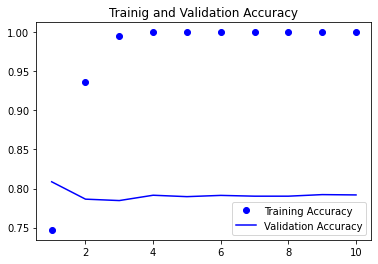

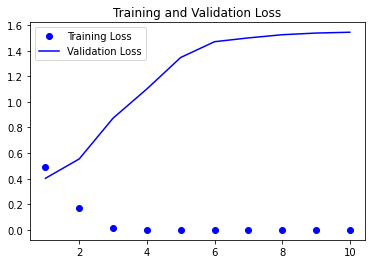

In [120]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title('Trainig and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [121]:
model.evaluate(test)

782/782 [==============================] - 7s 8ms/step - loss: 1.6476 - acc: 0.7711


[1.6475614309310913, 0.771120011806488]

In [172]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, LSTM

model = Sequential()
model.add(Embedding(MAX_FEATURES,EMBEDDING_DIM))
# model.add(Flatten())
# model.add(Dense(32,activation='relu'))
# model.add(SimpleRNN(32,return_sequences=True))
# model.add(SimpleRNN(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


In [173]:
# model.layers[0].set_weights([embedding_matrix])
# model.layers[0].trainable=False

In [174]:
# model.layers[0].set_weights([embedding_matrix])
# model.layers[0].trainable=False
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc'])
history=model.fit(train.repeat(5),epochs=5,steps_per_epoch=int(20001/BATCH_SIZE),validation_data=val.repeat(5),validation_steps=int(5001/BATCH_SIZE))

Epoch 1/5
625/625 [==============================] - 40s 60ms/step - loss: 0.6013 - acc: 0.6619 - val_loss: 0.4167 - val_acc: 0.8115
Epoch 2/5
625/625 [==============================] - 39s 62ms/step - loss: 0.3649 - acc: 0.8471 - val_loss: 0.3906 - val_acc: 0.8249
Epoch 3/5
625/625 [==============================] - 38s 60ms/step - loss: 0.3069 - acc: 0.8767 - val_loss: 0.3948 - val_acc: 0.8257
Epoch 4/5
625/625 [==============================] - 42s 67ms/step - loss: 0.2700 - acc: 0.8933 - val_loss: 0.5323 - val_acc: 0.8235
Epoch 5/5
625/625 [==============================] - 45s 72ms/step - loss: 0.2543 - acc: 0.9027 - val_loss: 0.4000 - val_acc: 0.8235


In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title('Trainig and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()